In [1]:
RESULTS_PATH = "./results/contrastivity/pairs.csv"

In [2]:
import pandas as pd
import numpy as np

results = []


In [3]:
import transformers

from tqdm import tqdm
import itertools
import os

import torch
import re
import sklearn
import spacy


nlp = spacy.load("en_core_web_sm")

In [4]:
test = pd.read_pickle("./dataset_test.pkl")

documents = test["answer"]

gold_labels = test["author"] == "human_answers" # convention: 0: machine, 1: human, see detector.py


from detector_detectgpt import DetectorDetectGPT
from detector_radford import DetectorRadford
from detector_guo import DetectorGuo
detector_classes = [DetectorRadford,DetectorGuo, DetectorDetectGPT]

from explainer_wrappers import LIME_Explainer, SHAP_Explainer, Random_Explainer
explainer_classes = [SHAP_Explainer,LIME_Explainer] + [Random_Explainer] * 10

In [5]:
DEVICE = "cuda"
pattern = re.compile(r"<extra_id_\d+>")

# model used to generate perturbations
base_model_name="facebook/opt-350m"

In [6]:
base_model = transformers.AutoModelForCausalLM.from_pretrained(base_model_name, cache_dir="./.cache").to(DEVICE)
base_tokenizer = transformers.AutoTokenizer.from_pretrained(base_model_name, cache_dir="./.cache", padding_side='left',)

# Generate/Load documents
Generate or load documents from `RESULTS_PATH`

In [12]:
columns=["Detector", "Original", "Prompt", "Edited", "f(Original)", "f(Edited)"]

In [13]:
if os.path.isfile(RESULTS_PATH):
    df = pd.read_csv(RESULTS_PATH)
else: 
    df = pd.DataFrame([], columns=columns)
    # write headers (mode != "a")
    df.to_csv(RESULTS_PATH, encoding="UTF-8", index=False)
df

,Detector,Original,Prompt,Edited,f(Original),f(Edited)
0,DetectorRadford,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,1,0.0
1,DetectorRadford,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,1,0.0
2,DetectorRadford,"Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...",0,1.0
3,DetectorRadford,Institutional investors are organizations that...,Institutional investors are organizations that...,Institutional investors are organizations that...,0,1.0
4,DetectorRadford,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,1,0.0
...,...,...,...,...,...,...
910,DetectorDetectGPT,"I believe that capital gains do affect AGI, bu...","I believe that capital gains do affect AGI, bu...","I believe that capital gains do affect AGI, bu...",0,1.0
911,DetectorDetectGPT,"There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...",0,1.0
912,DetectorDetectGPT,I know it may not last longer but i was able t...,I know it may not last longer but i was able t...,I know it may not last longer but i was able t...,1,0.0
913,DetectorDetectGPT,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,0,1.0


In [14]:
df.groupby("Detector").count()

,Original,Prompt,Edited,f(Original),f(Edited)
Detector,,,,,
DetectorDetectGPT,305,305,305,305,305
DetectorGuo,305,224,224,305,224
DetectorRadford,305,305,305,305,305


In [15]:
df

,Detector,Original,Prompt,Edited,f(Original),f(Edited)
0,DetectorRadford,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,1,0.0
1,DetectorRadford,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,1,0.0
2,DetectorRadford,"Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...",0,1.0
3,DetectorRadford,Institutional investors are organizations that...,Institutional investors are organizations that...,Institutional investors are organizations that...,0,1.0
4,DetectorRadford,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,1,0.0
...,...,...,...,...,...,...
910,DetectorDetectGPT,"I believe that capital gains do affect AGI, bu...","I believe that capital gains do affect AGI, bu...","I believe that capital gains do affect AGI, bu...",0,1.0
911,DetectorDetectGPT,"There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...",0,1.0
912,DetectorDetectGPT,I know it may not last longer but i was able t...,I know it may not last longer but i was able t...,I know it may not last longer but i was able t...,1,0.0
913,DetectorDetectGPT,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,0,1.0


In [16]:
for detector_class in detector_classes:
    detector = detector_class()
    for document in tqdm(documents, desc="Generating perturbations"): # only use those where f(x) = human
        np.random.seed(42)
        torch.manual_seed(42)

        if df[df["Detector"] == detector.__class__.__name__]["Original"].str.contains(document, regex=False).any(): # check if document is in csv, if yes, skip
            continue
        doc = nlp(document)
        n_tokens_original = len(base_tokenizer(document, return_tensors="pt", padding=True).to(DEVICE).input_ids[0])

        substrings = [''.join(token.text_with_ws for token in doc[:-i]) for i in range(1,len(document)) ]
        substrings = [substring for substring in substrings if substring != ""] # at least one token

        n_generations_per_lenght = 5
        substrings = list(itertools.chain.from_iterable(itertools.repeat(s, n_generations_per_lenght) for s in substrings))

        batch_size = 20 # adjust so it fits in your GPU memory
        prediction_original = detector.predict_label([document])[0]
        row = (detector.__class__.__name__, document, None, None, prediction_original, None) # to mark the document in the csv cache if no pair is found
        for batch in (sklearn.utils.gen_batches(len(substrings), batch_size)):
            encoded = base_tokenizer(substrings[batch], return_tensors="pt", padding=True).to(DEVICE)


            outputs = base_model.generate(**encoded, min_length=n_tokens_original-5, max_length=n_tokens_original+5, do_sample=True, pad_token_id=base_tokenizer.eos_token_id, eos_token_id=base_tokenizer.eos_token_id)
            decoded = base_tokenizer.batch_decode(outputs, skip_special_tokens=True)

            predictions = detector.predict_label(decoded)
            
            if any(predictions != prediction_original):
                first_new_label = (predictions!=prediction_original).argmax(axis=0)
                assert decoded[first_new_label] != document
                assert predictions[first_new_label] != prediction_original
                #                                   original  prompt                              first instance that flips label
                row = (detector.__class__.__name__, document, substrings[batch][first_new_label], decoded[first_new_label], prediction_original, predictions[first_new_label])
                break
        pd.DataFrame([row], columns=columns).to_csv(RESULTS_PATH, mode="a", encoding="UTF-8", index=False, header=False)


Generating perturbations: 100%|██████████| 305/305 [00:00<00:00, 364.84it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Generating perturbations: 100%|██████████| 305/305 [00:00<00:00, 1525.00it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Generating perturbations: 100%|██████████| 305/305 [00:00<00:00, 851.95it/s] 


In [17]:
df = pd.read_csv(RESULTS_PATH)

In [18]:
df = df.dropna()
df

,Detector,Original,Prompt,Edited,f(Original),f(Edited)
0,DetectorRadford,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,I've heard of handyman type people making a li...,1,0.0
1,DetectorRadford,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,No. Securities brokers/dealers in the United S...,1,0.0
2,DetectorRadford,"Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...","Yes, buying REITs (Real Estate Investment Trus...",0,1.0
3,DetectorRadford,Institutional investors are organizations that...,Institutional investors are organizations that...,Institutional investors are organizations that...,0,1.0
4,DetectorRadford,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,Hello and Welcome to ‘Ask A Doctor’ service.I ...,1,0.0
...,...,...,...,...,...,...
910,DetectorDetectGPT,"I believe that capital gains do affect AGI, bu...","I believe that capital gains do affect AGI, bu...","I believe that capital gains do affect AGI, bu...",0,1.0
911,DetectorDetectGPT,"There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...","There are many potential causes of fever, shiv...",0,1.0
912,DetectorDetectGPT,I know it may not last longer but i was able t...,I know it may not last longer but i was able t...,I know it may not last longer but i was able t...,1,0.0
913,DetectorDetectGPT,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,Online stock brokers typically get their real-...,0,1.0


In [19]:
df.groupby(["Detector", "f(Edited)"]).count()

Original  Prompt  Edited  f(Original)
Detector          f(Edited)                                       
DetectorDetectGPT 0.0              80      80      80           80
                  1.0             225     225     225          225
DetectorGuo       0.0              68      68      68           68
                  1.0             156     156     156          156
DetectorRadford   0.0             156     156     156          156
                  1.0             149     149     149          149

## Plot metrics of perturbed documents

In [20]:
df["Tokens New Part"] = df.apply(lambda row : len(nlp(row["Edited"].replace(row["Prompt"], ""))) , axis=1)
df["Tokens Original Part"] = df.apply(lambda row : len(nlp(row["Original"].replace(row["Prompt"], ""))) , axis=1)
df["Tokens Prompt"] = df.apply(lambda row : len(nlp(row["Prompt"])) , axis=1)
df["Tokens Document"] = df.apply(lambda row : len(nlp(row["Original"])) , axis=1)

In [21]:
df["Tokens Edited"] = (df["Tokens Document"] - df["Tokens Prompt"])
df["Tokens Edited Proportion"] = (df["Tokens Document"] - df["Tokens Prompt"]) / df["Tokens Document"]

In [22]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'sans-serif',
    "font.sans-serif": "Helvetica",
    'text.usetex': True,
    'pgf.rcfonts': False,
})

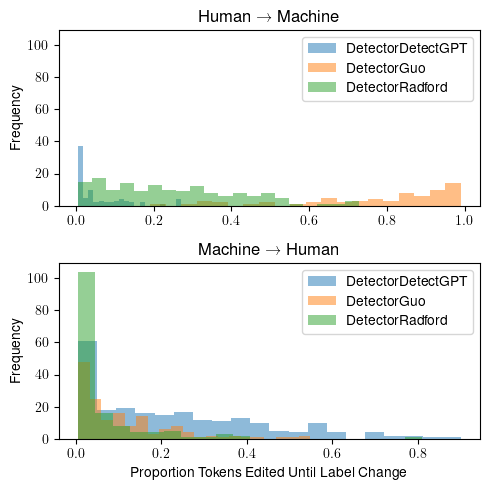

In [23]:
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(5,5))
df[df["f(Original)"] == 1].groupby(["Detector"])["Tokens Edited Proportion"].plot.hist(alpha=0.5, bins=20, ax=ax1 )
ax1.legend(loc="upper right")
ax1.set_title("Human → Machine")

df[df["f(Original)"] == 0].groupby(["Detector"])["Tokens Edited Proportion"].plot.hist(alpha=0.5, bins=20, ax=ax2 )
ax2.legend(loc="upper right")
ax2.set_title("Machine → Human")
ax2.set_xlabel("Proportion Tokens Edited Until Label Change ")
f.tight_layout()
plt.savefig('./figures/contrastivity-label-flip.pgf')
plt.show()

In [24]:
df[df["Tokens Edited Proportion"] <= 0.50].groupby("Detector")["Tokens Edited"].describe()

,count,mean,std,min,25%,50%,75%,max
Detector,,,,,,,,
DetectorDetectGPT,279.0,18.706093,20.619881,1.0,2.0,10.0,30.0,79.0
DetectorGuo,162.0,16.753086,16.863376,1.0,3.0,10.5,24.0,73.0
DetectorRadford,290.0,15.651724,15.906716,1.0,2.0,9.0,25.0,72.0


In [25]:
df[df["Tokens Edited Proportion"] <= 0.50].groupby("Detector")["Tokens Edited Proportion"].describe()

,count,mean,std,min,25%,50%,75%,max
Detector,,,,,,,,
DetectorDetectGPT,279.0,0.140310,0.138778,0.005495,0.018012,0.094118,0.236542,0.500000
DetectorGuo,162.0,0.116627,0.113449,0.005747,0.023695,0.078138,0.164426,0.480519
DetectorRadford,290.0,0.136003,0.139582,0.005917,0.018868,0.072805,0.236536,0.500000


# Run Experiment/Calculate Scores

In [26]:
df = df[df["Tokens Edited Proportion"] <= 0.5]

In [31]:
import krippendorff

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
columns = ["Explainer",
          "Detector",
          "f(d) → f(m)",
          "Mean FI Original Cut Part",
          "Mean FI Edited New Part",
          "Mean FI Original Common Part",
          "Mean FI Edited Common Part",
          "[Score 1] cos sim",
          "[Score 1] Krippendorff",
          "[Score 4]",
          "[Score 2]",
          "[Score 3]",
          "Tokens Edited Proportion"]

In [34]:
results = []

for detector_class in detector_classes:
    detector = detector_class()
    random_run = 1
    for explainer_class in explainer_classes:
            if explainer_class == Random_Explainer:
                 explainer = explainer_class(detector, seed=random_run) # 10 random runs per detector (Random_Explainer is 10 times in explainer_classes)
                 random_run += 1
            else:
                explainer = explainer_class(detector)
            for idx, (_, original, prompt, edited, f_original, f_edited, _,_,_,_,_,tokens_edited_proportion) in tqdm(list(df[df["Detector"] == detector.__class__.__name__].iterrows()), desc="Gathering results"):
                target_label = f_edited
                # if not (explainer.is_cached(original)) or not(explainer.is_cached(edited)):
                #      continue
                # The generation strategy above uses spacy's tokenizer (where punctuation chars are end up in seperate tokens). 
                # The explanation methods have their own tokenizers and FI scores are reported irt to those tokens
                # For LIME, multiple punctuation chars can end up in the same token e.g.: "!)" is one token, "!" too, "#+#++..,++##" as well. 
                # This is problematic when comparing explanations:
                # i.e. this can fail: assert explainer.tokenize(original)[0:lenght_promt] == explainer.tokenize(edited)[0:lenght_promt]
                
                # For this experiment, it is only important to separate the "prompt", which is the common part between the two documents, from the generated/cut parts
                # Determining the bounds of the prompt has to be done AFTER tokenization:
                # Strategy: change bounds until assert explainer.tokenize(original)[0:lenght_promt] == explainer.tokenize(edited)[0:lenght_promt] passes
                lenght_promt = len(explainer.tokenize(prompt)) # this would suffice for SHAP, but not for lime (because it sometimes collapses punctuation chars into one token) 
                while explainer.tokenize(original)[0:lenght_promt] != explainer.tokenize(edited)[0:lenght_promt] or len(explainer.tokenize(original)[lenght_promt:]) == 0 or len(explainer.tokenize(edited)[lenght_promt:]) == 0:    
                    lenght_promt -= 1 
                lenght_promt = max(lenght_promt, 1) # if the first word is followed by a punctuation char, e.g., "Example! Is a sentence." and the prompt is just "Example", the loop above would set lenght_promt=0. This happens as LIME tokenizes this to ['Example!', 'Is', 'a', 'sentence.']
                assert explainer.tokenize(original)[1:lenght_promt] == explainer.tokenize(edited)[1:lenght_promt]
                       
                # get cut/edited parts
                exp_original_cut_part = explainer.get_fi_scores(original, fill=True)[target_label][lenght_promt:] # TODO hard coded: "machine"
                exp_edited_new_part = explainer.get_fi_scores(edited, fill=True)[target_label][lenght_promt:] # setting fill=True returns all features (not just the top_k) 
                fi_scores_exp_original_cut_part = np.array([fi_score for _, fi_score in exp_original_cut_part])
                fi_scores_exp_edited_new_part =   np.array([fi_score for _, fi_score in exp_edited_new_part])
                

                # get common part
                exp_original_common_part = explainer.get_fi_scores(original, fill=True)[target_label][0:lenght_promt]
                exp_edited_common_part = explainer.get_fi_scores(edited, fill=True)[target_label][0:lenght_promt]
                fi_scores_exp_original_common_part = np.array([fi_score for _, fi_score in exp_original_common_part])
                fi_scores_exp_edited_common_part=    np.array([fi_score for _, fi_score in exp_edited_common_part])
                
                # build result row
                score_2_new_and_cut_parts_opposite = np.mean(fi_scores_exp_edited_new_part) > np.mean(fi_scores_exp_original_cut_part)
                score_4_max_fi_in_new_part = fi_scores_exp_edited_new_part.max() > fi_scores_exp_edited_common_part.max()
                score_3_new_average_higher_than_common = np.mean(fi_scores_exp_edited_new_part) > np.mean(fi_scores_exp_edited_common_part)

                cannonical_form = np.vstack([fi_scores_exp_original_common_part, fi_scores_exp_edited_common_part])
                
                assert len(fi_scores_exp_original_cut_part) > 0
                assert len(fi_scores_exp_edited_new_part) > 0
                assert len(fi_scores_exp_original_common_part) > 0
                assert len(fi_scores_exp_edited_common_part) > 0

                score_1_k_alpha = None
                if np.all(cannonical_form==0): # the krippendorff library requires items to not all be the same
                    score_1_k_alpha = 1
                else:
                    score_1_k_alpha = krippendorff.alpha(cannonical_form, level_of_measurement="interval")

                score_1_cos_sim = cosine_similarity(fi_scores_exp_original_common_part.reshape(1, -1),fi_scores_exp_edited_common_part.reshape(1, -1))[0,0]
                row =     (
                     explainer.__class__.__name__, 
                     detector.__class__.__name__, 
                     "m → h" if target_label else "h → m",
                     np.mean(fi_scores_exp_original_cut_part), 
                     np.mean(fi_scores_exp_edited_new_part), 
                     np.mean(fi_scores_exp_original_common_part), 
                     np.mean(fi_scores_exp_edited_common_part),  
                     score_1_cos_sim,               
                     score_1_k_alpha,                             
                     score_4_max_fi_in_new_part, 
                     score_2_new_and_cut_parts_opposite,
                     score_3_new_average_higher_than_common,
                     tokens_edited_proportion
                     )
                results.append(row)



Gathering results: 100%|██████████| 290/290 [00:14<00:00, 19.80it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Gathering results: 100%|██████████| 162/162 [00:09<00:00, 16.65it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Gathering results: 100%|██████████| 279/279 [00:11<00:00, 24.85it/s]


In [35]:
dff = pd.DataFrame(results, columns=columns)
dff["Explainer"] = dff["Explainer"].str.replace("_Explainer", "")


In [36]:
from scipy.stats.mstats import ttest_1samp

In [37]:
export_cols = [
          "[Score 1] cos sim",
          "[Score 1] Krippendorff",          
          "[Score 2]",
          "[Score 3]",
          "[Score 4]",
]

In [69]:
# some formatting functions
def get_p_asterisks(group):
    val =  group.mean()
   # print(group.name)
    _, p = ttest_1samp(group, popmean=0 if "[Score 1]" in group.name else 0) # TODO
    if p <= 0.001:
        return "{:.2f}\\textsuperscript{{***}}".format(val)
    if p <= 0.01:
        return "{:.2f}\\textsuperscript{{**}}".format(val)
    if p <= 0.05:
        return "{:.2f}\\textsuperscript{{*}}".format(val)
    if p > 0.05:
        return "{:.2f}\\textsuperscript{{ns}}".format(val)


def df_to_latex(styled_df, caption="TODO", label="TODO"):
    return styled_df.to_latex(environment="longtable", convert_css=True, clines="all;data", hrules=True, caption=caption, label=label)

In [59]:
dff

,Explainer,Detector,f(d) → f(m),Mean FI Original Cut Part,Mean FI Edited New Part,Mean FI Original Common Part,Mean FI Edited Common Part,[Score 1] cos sim,[Score 1] Krippendorff,[Score 4],[Score 2],[Score 3],Tokens Edited Proportion
0,SHAP,DetectorRadford,h → m,-0.010459,0.006581,-0.012620,-0.013571,0.818764,0.718013,True,True,True,0.469136
1,SHAP,DetectorRadford,h → m,-0.008298,0.006963,-0.006402,-0.009255,0.860101,0.749235,True,True,True,0.297101
2,SHAP,DetectorRadford,m → h,0.004678,0.049227,0.000230,0.004298,0.554081,0.531658,True,True,True,0.013072
3,SHAP,DetectorRadford,m → h,0.048430,0.037058,-0.001217,0.001502,0.567644,0.561619,True,False,True,0.025424
4,SHAP,DetectorRadford,h → m,-0.011686,0.011136,-0.011209,-0.008203,0.800283,0.729157,True,True,True,0.260274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,Random,DetectorDetectGPT,m → h,-0.602835,0.517509,-0.516423,0.462262,-0.748221,-0.739425,False,True,True,0.190476
8768,Random,DetectorDetectGPT,m → h,-0.488144,0.488209,-0.458095,0.571481,-0.698844,-0.686966,False,True,False,0.304348
8769,Random,DetectorDetectGPT,m → h,-0.634833,0.500316,-0.463342,0.506882,-0.740778,-0.733271,True,True,False,0.231250
8770,Random,DetectorDetectGPT,h → m,0.861041,-0.543059,0.535265,-0.488952,-0.766122,-0.754024,False,False,False,0.032967


In [60]:
# style_bold = dff.set_index(["Explainer", "Detector","f(d) → f(m)"])[export_cols].groupby(["Detector","Explainer",  "f(d) → f(m)"]).mean().style.highlight_max(props="font-weight: bold;")

In [70]:
def style_dff(dff, groupby):
    p_results = dff.set_index(["Explainer", "Detector","f(d) → f(m)"])[export_cols].groupby(groupby).agg(
    {
          "[Score 1] cos sim": ["count", "mean"],
          "[Score 1] Krippendorff": "mean",          
          "[Score 2]": "mean",
          "[Score 3]": "mean",
          "[Score 4]": "mean",
        }
    )

    p_results[('n')] = p_results[('[Score 1] cos sim', 'count')]
    p_results = p_results.drop([('[Score 1] cos sim', 'count')], axis=1)

    p_results = p_results[[list(p_results.columns)[-1]] + list(p_results.columns)[:-1]]
    p_results.columns = [a for a, _ in p_results.columns]

    p_results = p_results.style#.apply(highlight_max, subset=p_results.columns[1:], axis=None)
    p_results.hide("[Score 4]", axis=1)
    return p_results


In [71]:
p_results_detector_level = style_dff(dff, groupby=["Detector","Explainer",  "f(d) → f(m)"])
display(p_results_detector_level)
p_results_aggregate_level = style_dff(dff, groupby=["Explainer"])
display(p_results_aggregate_level)

,n,[Score 1] cos sim,[Score 1] Krippendorff,[Score 2],[Score 3]
Explainer,,,,,
LIME,731,0.128035,0.079196,0.597811,0.586867
Random,7310,0.011732,-0.362194,0.485910,0.497948
SHAP,731,0.425250,0.360149,0.798906,0.774282


In [68]:

out = df_to_latex(p_results_detector_level, label="contrastivity-explainer-detector-direction", caption="Scores per detector, explainer and direction of change. For scores 2-4, higher is better")
out += df_to_latex(p_results_aggregate_level, label="contrastivity-aggregate", caption="Aggregate Scores per Detector. For scores 2-4, higher is better")
with open("figures/tables_contrastivity.tex", "w", encoding="UTF-8") as text_file:
    text_file.write(out)

In [ ]:
results_explainer_level = dff.set_index(["Explainer", "Detector","f(d) → f(m)"]).groupby(["Explainer"]).mean()
results_explainer_level

,Mean FI Original Cut Part,Mean FI Edited New Part,Mean FI Original Common Part,Mean FI Edited Common Part,[Score 1] cos sim,[Score 1] Krippendorff,[Score 4],[Score 2],[Score 3],Tokens Edited Proportion
Explainer,,,,,,,,,,
LIME,-0.002161,0.001759,-0.002364,-0.000140,0.128035,0.079196,0.231190,0.597811,0.586867,0.133353
Random,0.009392,-0.012340,0.012599,-0.011856,0.011732,-0.362194,0.167031,0.485910,0.497948,0.133353
SHAP,-0.008080,0.010864,-0.003247,-0.002930,0.425250,0.360149,0.417237,0.798906,0.774282,0.133353


In [57]:
dff.set_index(["Explainer", "Detector","f(d) → f(m)"]).groupby(["Explainer"])["[Score 1] cos sim"].describe()

,count,mean,std,min,25%,50%,75%,max
Explainer,,,,,,,,
LIME,731.0,0.128035,0.208256,-0.477431,0.000000,0.042015,0.204472,0.913152
Random,7310.0,0.011732,0.752478,-1.000000,-0.751417,0.674637,0.752310,1.000000
SHAP,731.0,0.425250,0.347706,-1.000000,0.133047,0.460323,0.734330,1.000000
